In [2]:
#Loading modules

import deepchem as dc
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import Features
from rdkit.Chem import Fragments as fr
from rdkit.Chem import rdMolDescriptors
import tensorflow as tf

import pandas as pd

from matplotlib import pyplot as plt

import numpy as np

from sklearn import metrics
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings("ignore")

# Ensemble learning


In [83]:
#First lets take Richard's featurisation method (shortened):

#Loading the datasets
datasets = dc.molnet.load_tox21(featurizer='GraphConv', splitter='random')


tasks, datasets, transformers = datasets



#Transforming dataset into a pandas dataframe
train_dataset, valid_dataset, test_dataset = datasets

train_df = train_dataset.to_dataframe()
test_dataset = test_dataset.to_dataframe()
valid_dataset = valid_dataset.to_dataframe()

#This line concatenates all the dataframes, we will resplit them later with SKLEARN
dataset = pd.concat([train_df, test_dataset, valid_dataset])

dataset

,X,y1,y2,y3,y4,y5,y6,y7,y8,y9,...,w4,w5,w6,w7,w8,w9,w10,w11,w12,ids
0,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,1.186419,0.000000,1.058113,0.000000,0.000000,CCOC(=O)C(=O)c1csc(NC=O)n1
1,<deepchem.feat.mol_graphs.ConvMol object at 0x...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,1.145708,1.050492,1.029118,1.186419,1.038037,1.058113,0.000000,1.063423,CN(CCOc1ccc(NS(C)(=O)=O)cc1)CCc1ccc(NS(C)(=O)=...
2,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.054158,1.145708,1.050492,1.029118,1.186419,1.038037,1.058113,1.182927,1.063423,CCCCCCCCCCCCCCCC(=O)OCC
3,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.054158,1.145708,1.050492,1.029118,0.000000,1.038037,0.000000,1.182927,1.063423,O=c1oc2cc(O)ccc2s1
4,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.054158,1.145708,1.050492,1.029118,6.364256,1.038037,1.058113,6.466667,1.063423,CCOP(=S)(OCC)Oc1nc(Cl)c(Cl)cc1Cl
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
778,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.000000,0.000000,0.000000,0.000000,6.364256,0.000000,0.000000,0.000000,0.000000,NC(=O)C(=O)NN=Cc1ccc([N+](=O)[O-])o1
779,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.054158,1.145708,1.050492,1.029118,0.000000,1.038037,0.000000,1.182927,1.063423,CC(=O)OC[C@H]1O[C@@H](O)[C@H](OC(=O)c2ccccc2C(...
780,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.054158,1.145708,1.050492,1.029118,6.364256,1.038037,1.058113,1.182927,16.767081,c1cc2ccc3ccc4ccc5cccc6c(c1)c2c3c4c56
781,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.054158,1.145708,1.050492,1.029118,1.186419,1.038037,1.058113,0.000000,16.767081,O=Cc1ccccc1[N+](=O)[O-]


In [84]:
#Lets take just the y values and concatenate them into a single value (1 = toxic, 0 = non-toxic)

dataset = dataset[['ids', 'y1', 'y2', 'y3', 'y4', 'y5', 'y6', 'y7']]

dataset['tox'] = dataset.sum(axis=1)
dataset['tox_bin'] = dataset['tox'].apply(lambda x: 1 if x > 0 else 0)

dataset.iloc[1:100]

,ids,y1,y2,y3,y4,y5,y6,y7,tox,tox_bin
1,CN(CCOc1ccc(NS(C)(=O)=O)cc1)CCc1ccc(NS(C)(=O)=...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
2,CCCCCCCCCCCCCCCC(=O)OCC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,O=c1oc2cc(O)ccc2s1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,CCOP(=S)(OCC)Oc1nc(Cl)c(Cl)cc1Cl,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1
5,CCCCCCCC1CCCC1=O,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...
95,CNS(=O)(=O)c1cc(C(=O)N2CCC(CCN3C4CCC3CC(n3c(C)...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
96,Cc1ncc([N+](=O)[O-])n1C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
97,O=C(O)c1cc(I)cc(I)c1I,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1
98,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [85]:
#Next lets featurise our dataset using Richard's featurisation method
#However I will only take the top most toxic functional groups

toxic_grps = {
    'isothiocyanate' : fr.fr_isothiocyan,
    'C_S': fr.fr_C_S,
    'dihydropyridine' : fr.fr_dihydropyridine,
    'nitro_arom' : fr.fr_nitro_arom,
    'phenol_not_ortho': fr.fr_phenol_noOrthoHbond,
    'nitro_non_ortho' : fr.fr_nitro_arom_nonortho,
    'phenol' : fr.fr_phenol,
    'aromatic_OH': fr.fr_Ar_OH,
    'furan' : fr.fr_furan,
    'terminal_acetylene' : fr.fr_term_acetylene,
    'thiazole' : fr.fr_thiazole,
    'nitro' : fr.fr_nitro,
    'hydrazone' : fr.fr_hdrzone,
    'allylic_oxide' : fr.fr_allylic_oxid,
    'ketone': fr.fr_ketone,
    'bicyclic': fr.fr_bicyclic,
    'azo' : fr.fr_azo,
    'aromatic_N': fr.fr_ArN,
    'aliphatic_COO': fr.fr_Al_COO,
    'epoxide' : fr.fr_epoxide,
    'thiocyanate' : fr.fr_thiocyan,
    'aniline' : fr.fr_aniline,
    'alkyl_halide' : fr.fr_alkyl_halide,
    'pyridine' : fr.fr_pyridine,
    'isocyanate' : fr.fr_isocyan,
    'oxazole' : fr.fr_oxazole,
    'ketone_topliss' : fr.fr_ketone_Topliss,
    'imidazole' : fr.fr_imidazole,
    'para_hydroxylation' : fr.fr_para_hydroxylation,
    'benzene' : fr.fr_benzene,
    'thiophene' : fr.fr_thiophene,
    'hydrzine' : fr.fr_hdrzine,
    'phos_ester' : fr.fr_phos_ester,
    'phos_acid' : fr.fr_phos_acid,
}

In [86]:
featurized = dataset

from rdkit.Chem.FilterCatalog import FilterCatalog, FilterCatalogParams
from rdkit.Chem import Descriptors as ds

params_pains = FilterCatalogParams()
params_pains.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS)
pains = FilterCatalog(params_pains)

params_brenk = FilterCatalogParams()
params_brenk.AddCatalog(FilterCatalogParams.FilterCatalogs.BRENK)
brenk = FilterCatalog(params_brenk)

params_nih = FilterCatalogParams()
params_nih.AddCatalog(FilterCatalogParams.FilterCatalogs.NIH)
nih = FilterCatalog(params_nih)


SMILES_strings = dataset['ids']
mol = [Chem.MolFromSmiles(formula) for formula in SMILES_strings]

for row in featurized.index:
    molecule = mol[row]
    for grp in toxic_grps.keys():
        featurized.loc[row, grp] = toxic_grps[grp](molecule)
    featurized.loc[row, 'pain'] = 1 if pains.HasMatch(molecule) else 0
    featurized.loc[row, 'brenk'] = 1 if pains.HasMatch(molecule) else 0
    featurized.loc[row, 'nih'] = 1 if pains.HasMatch(molecule) else 0




featurized


[08:56:06] WARNING: not removing hydrogen atom without neighbors


,ids,y1,y2,y3,y4,y5,y6,y7,tox,tox_bin,...,imidazole,para_hydroxylation,benzene,thiophene,hydrzine,phos_ester,phos_acid,pain,brenk,nih
0,CCOC(=O)C(=O)c1csc(NC=O)n1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CN(CCOc1ccc(NS(C)(=O)=O)cc1)CCc1ccc(NS(C)(=O)=...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,CCCCCCCCCCCCCCCC(=O)OCC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,O=c1oc2cc(O)ccc2s1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,CCOP(=S)(OCC)Oc1nc(Cl)c(Cl)cc1Cl,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
778,NC(=O)C(=O)NN=Cc1ccc([N+](=O)[O-])o1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
779,CC(=O)OC[C@H]1O[C@@H](O)[C@H](OC(=O)c2ccccc2C(...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
780,c1cc2ccc3ccc4ccc5cccc6c(c1)c2c3c4c56,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
781,O=Cc1ccccc1[N+](=O)[O-],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [87]:
#Great, lets also add a few extra features such as halogens and heavy atoms (>=F)

#This function will count the number of halogens:
def halogen_count(molecule):
    return fr.fr_halogen(molecule)

def heavy_atom_count(molecule):
    count = 0
    for atom in molecule.GetAtoms():
        if atom.GetAtomicNum() >= 9:
            count += 1
    return count


halogens = [halogen_count(molecule) for molecule in mol]
heaviest_atoms = [heavy_atom_count(molecule) for molecule in mol]
molWt = [ds.MolWt(molecule) for molecule in mol]
het_atoms = [ds.NumHeteroatoms(molecule) for molecule in mol]
aromatic_ring = [ds.NumAromaticRings(molecule) for molecule in mol]


featurized['molWt'] = molWt
featurized['het_atoms'] = het_atoms
featurized['aromatic_ring'] = aromatic_ring
featurized['halogens'] = halogens
featurized['heavy_atoms'] = heaviest_atoms

featurized

,ids,y1,y2,y3,y4,y5,y6,y7,tox,tox_bin,...,phos_ester,phos_acid,pain,brenk,nih,molWt,het_atoms,aromatic_ring,halogens,heavy_atoms
0,CCOC(=O)C(=O)c1csc(NC=O)n1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,228.229,7,1,0,1
1,CN(CCOc1ccc(NS(C)(=O)=O)cc1)CCc1ccc(NS(C)(=O)=...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,...,0.0,0.0,0.0,0.0,0.0,441.575,10,2,0,2
2,CCCCCCCCCCCCCCCC(=O)OCC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,284.484,2,0,0,0
3,O=c1oc2cc(O)ccc2s1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,168.173,4,2,0,1
4,CCOP(=S)(OCC)Oc1nc(Cl)c(Cl)cc1Cl,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1,...,0.0,0.0,0.0,0.0,0.0,350.591,9,1,3,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
778,NC(=O)C(=O)NN=Cc1ccc([N+](=O)[O-])o1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,226.148,9,1,0,0
779,CC(=O)OC[C@H]1O[C@@H](O)[C@H](OC(=O)c2ccccc2C(...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,722.605,19,2,0,0
780,c1cc2ccc3ccc4ccc5cccc6c(c1)c2c3c4c56,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1,...,0.0,0.0,1.0,1.0,1.0,276.338,0,6,0,0
781,O=Cc1ccccc1[N+](=O)[O-],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,151.121,4,1,0,0


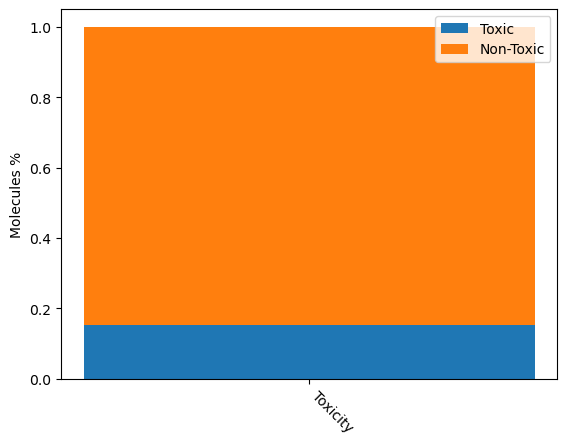

In [88]:
#We can also drop the 'y' columns

#lets first drop our 'y' values
featurized_dropped = featurized.drop(['y1', 'y2', 'y3', 'y4', 'y5', 'y6', 'y7'], axis=1)


#Now lets do a test train split
from sklearn.model_selection import train_test_split


train, test = train_test_split(featurized_dropped, test_size=0.1)

percent_toxic = len(train[train['tox'] == 1]) / len(train)
percent_non_toxic = 1- percent_toxic


#Lets plot the train_df as a stacked bar graph:
ax=plt.bar('Toxicity',percent_toxic, label='Toxic')
plt.bar('Toxicity',percent_non_toxic, bottom= percent_toxic, label='Non-Toxic')
plt.xticks(rotation=-45, ha='left')
plt.ylabel("Molecules %")
plt.legend()



In [89]:
#We have a heavily unbalanced dataset, lets fix that!

print(len(train[train['tox'] == 1]))
print(len(train[train['tox'] == 0]))

from sklearn.utils import resample


train_majority = train[train['tox'] == 0]
train_minority = train[train['tox'] == 1]

train_min_upsampled = resample(train_minority, 
                               replace=True, 
                               n_samples=int(len(train_majority)/2))

train_max_downsampled = resample(train_majority, 
                                 replace=False, 
                                 n_samples=int(len(train_minority)*3))


train_upsampled = pd.concat([train_min_upsampled, train_max_downsampled])
train_upsampled

1073
5331


,ids,tox,tox_bin,isothiocyanate,C_S,dihydropyridine,nitro_arom,phenol_not_ortho,nitro_non_ortho,phenol,...,phos_ester,phos_acid,pain,brenk,nih,molWt,het_atoms,aromatic_ring,halogens,heavy_atoms
5952,CCOP(=O)(OCC)Oc1ccc([N+](=O)[O-])cc1,1.0,1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,275.197,8,1,0,1
6114,C[C@@H]1O[C@@H](OC[C@H]2O[C@@H](Oc3c(-c4ccc(O)...,1.0,1,0.0,0.0,0.0,0.0,4.0,0.0,4.0,...,0.0,0.0,1.0,1.0,1.0,610.521,16,3,0,0
3130,CCCCNC(=O)n1c(NC(=O)OC)nc2ccccc21,1.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,290.323,7,2,0,0
2491,COc1cc([C@@H]2c3cc4c(cc3C(O[C@@H]3O[C@@H]5CO[C...,1.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,668.541,17,2,0,1
1312,CCCCC(CC)COC(=O)c1ccc(C(=O)OCC(CC)CCCC)c(C(=O)...,1.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,546.789,6,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1899,O=P(O)(Oc1ccccc1)Oc1ccccc1,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,250.190,5,2,0,1
2763,O=C1c2ccccc2C(=O)C1c1ccc(Cl)cc1,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,256.688,3,2,1,1
4538,Cc1ncc(CO)c(CN)c1O,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,168.196,4,1,0,0
4237,NC(=O)Cc1cccc(C(=O)c2ccccc2)c1N,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,254.289,4,2,0,0


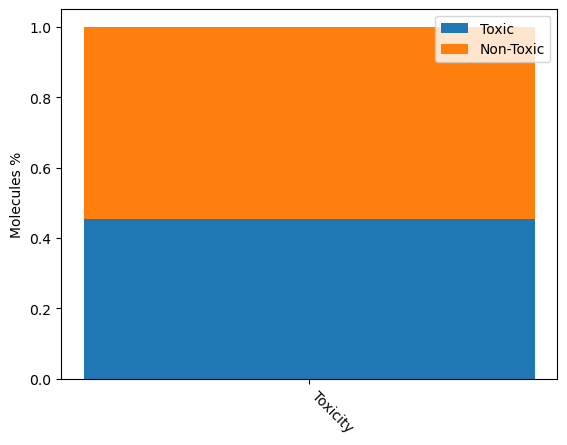

In [90]:
percent_toxic = len(train_upsampled[train_upsampled['tox'] == 1]) / len(train_upsampled)
percent_non_toxic = 1- percent_toxic


#Lets plot the train_df as a stacked bar graph:
ax=plt.bar('Toxicity',percent_toxic, label='Toxic')
plt.bar('Toxicity',percent_non_toxic, bottom= percent_toxic, label='Non-Toxic')
plt.xticks(rotation=-45, ha='left')
plt.ylabel("Molecules %")
plt.legend()

In [91]:
#Thats better, lets now split our data into X and y

train_X = train_upsampled.drop(['ids'], axis=1).drop(['tox'], axis=1).drop(['tox_bin'], axis=1)
train_y = train_upsampled['tox_bin']

test_X = test.drop(['ids'], axis=1).drop(['tox'], axis=1).drop(['tox_bin'], axis=1)
test_y = test['tox_bin']

train_X

,isothiocyanate,C_S,dihydropyridine,nitro_arom,phenol_not_ortho,nitro_non_ortho,phenol,aromatic_OH,furan,terminal_acetylene,...,phos_ester,phos_acid,pain,brenk,nih,molWt,het_atoms,aromatic_ring,halogens,heavy_atoms
5952,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,275.197,8,1,0,1
6114,0.0,0.0,0.0,0.0,4.0,0.0,4.0,4.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,610.521,16,3,0,0
3130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,290.323,7,2,0,0
2491,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,668.541,17,2,0,1
1312,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,546.789,6,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1899,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,250.190,5,2,0,1
2763,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,256.688,3,2,1,1
4538,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,168.196,4,1,0,0
4237,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,254.289,4,2,0,0


In [92]:
#Lets see how balanced the dataset is:
train_y.value_counts()

0    3219
1    2665
Name: tox_bin, dtype: int64

In [93]:
#Lets first train a simple SGD Classifier

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier

#We should first scale our data
scaler = StandardScaler()

train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)

sgd = SGDClassifier()
sgd.fit(train_X, train_y)

SGDClassifier()

In [94]:
cross_val_score(sgd, test_X, test_y, cv =5, scoring='accuracy')

array([0.68152866, 0.70700637, 0.7133758 , 0.65605096, 0.72435897])

In [95]:
#Thats not too bad, lets compare it to a random classifier

from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(train_X, train_y)

cross_val_score(dummy_clf, test_X, test_y, cv =5, scoring='accuracy')

array([0.75159236, 0.75159236, 0.75159236, 0.74522293, 0.75      ])

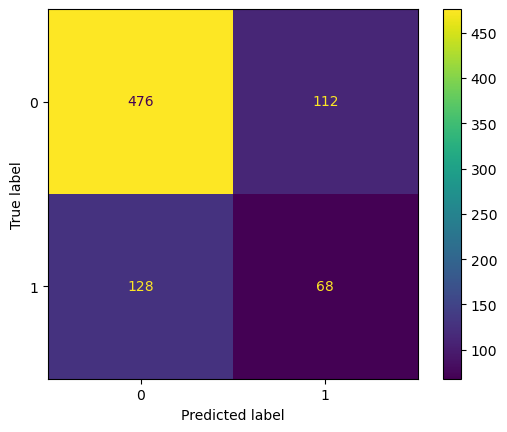

In [96]:
#Lets look at our confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(test_y, sgd.predict(test_X))

ConfusionMatrixDisplay(confusion_matrix=cm).plot()

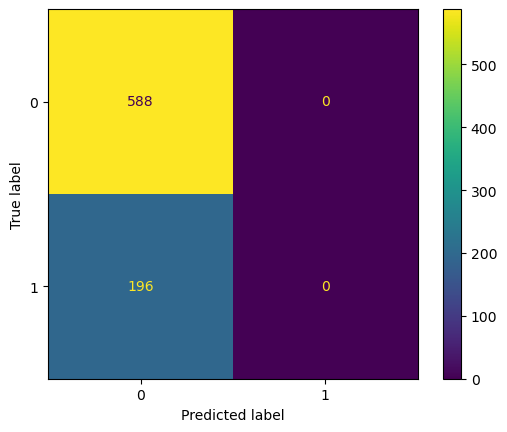

In [97]:
cm_dummy = confusion_matrix(test_y, dummy_clf.predict(test_X))

ConfusionMatrixDisplay(confusion_matrix=cm_dummy).plot()

In [98]:
#Hmm, these arent very good, lets train a random forest:

from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()

rf_clf.fit(train_X, train_y)


RandomForestClassifier()

In [99]:
cross_val_score(rf_clf, test_X, test_y, cv =5, scoring='accuracy')

array([0.72611465, 0.75796178, 0.76433121, 0.77070064, 0.74358974])

Model score: 0.32758620689655166


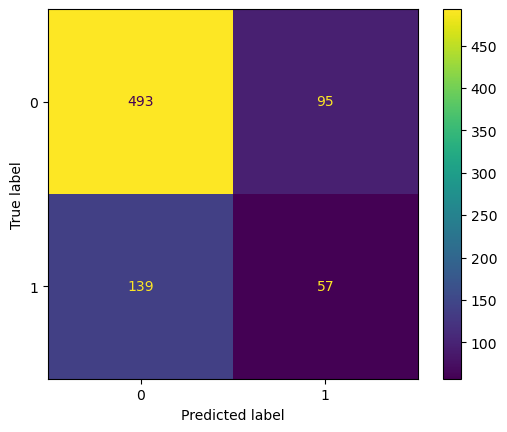

In [100]:
from sklearn.metrics import f1_score
predicted = rf_clf.predict(test_X)

score = f1_score(test_y, predicted)
cm = confusion_matrix(test_y, predicted)

print(f'Model score: {score}')
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [101]:
#Lets see if we can optimise this using GridSearchCV

from sklearn.model_selection import GridSearchCV


In [102]:

rf_clf = RandomForestClassifier(criterion='gini', max_features='log2')

grid = {
    'n_estimators': [350,400,450],
    'max_depth' : [13,14,15,16],
}


grid_search = GridSearchCV(estimator=rf_clf, param_grid=grid)

grid_search.fit(train_X, train_y)

GridSearchCV(estimator=RandomForestClassifier(max_features='log2'),
             param_grid={'max_depth': [13, 14, 15, 16],
                         'n_estimators': [350, 400, 450]})

In [103]:
grid_search.best_params_

{'max_depth': 16, 'n_estimators': 400}

In [104]:
rf_clf = RandomForestClassifier(**grid_search.best_params_)
rf_clf.fit(train_X, train_y)

RandomForestClassifier(max_depth=16, n_estimators=400)

In [105]:
pred = rf_clf.predict(test_X)

score = f1_score(test_y, pred)
print(f'f1 score: {score}')

f1 score: 0.42245989304812837


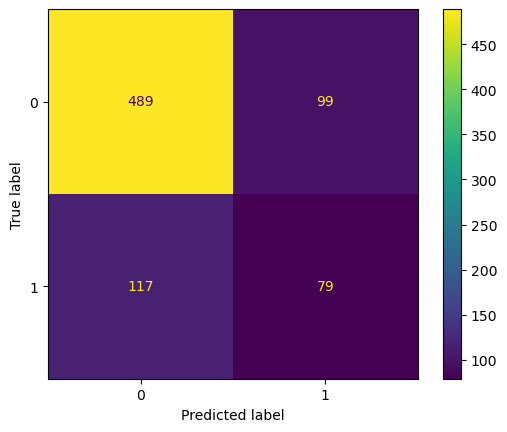

In [106]:
cm = confusion_matrix(test_y, pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

Text(0.5, 1.0, 'Precision Recall Curve')

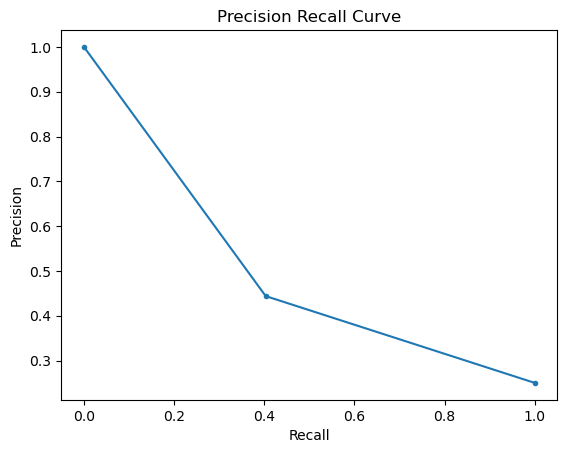

In [107]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(test_y, pred)

plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')

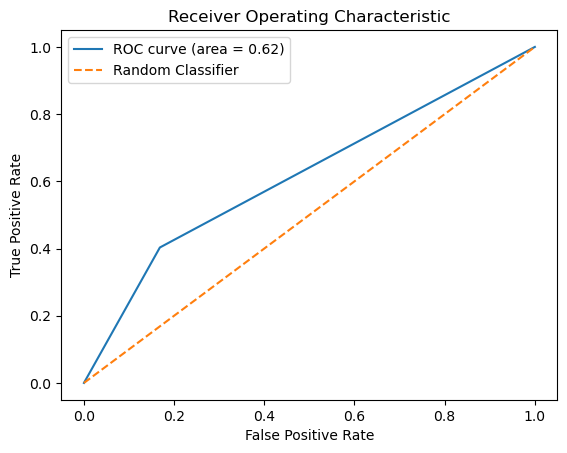

In [108]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(test_y, pred)

roc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc)
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()

In [109]:
from sklearn.svm import SVC

#Lets train an SVC classifier
svc_clf = SVC(probability=True)
svc_clf.fit(train_X, train_y)

y_pred = svc_clf.predict(test_X)
score = f1_score(test_y, y_pred)
print(f'f1 score: {score}')

f1 score: 0.4084507042253521


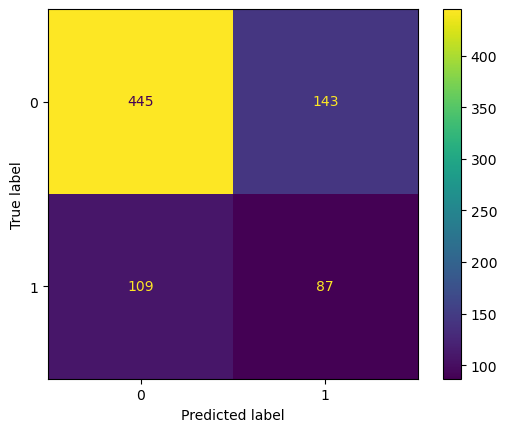

In [110]:
#This isn't too bad, lets look at the confusion matrix

cm = confusion_matrix(test_y, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [111]:
#We can see the biggest error is from false positives which isn't too bad for us
#We can set this threshold ourselves to reduce the false negatives even further:

class_probability = svc_clf.predict_proba(test_X)

threshold = 0.45
y_pred = np.where(class_probability[:,1] > threshold, 1, 0)
score = f1_score(test_y, y_pred)
print(f'f1 score: {score}')

f1 score: 0.4065040650406504


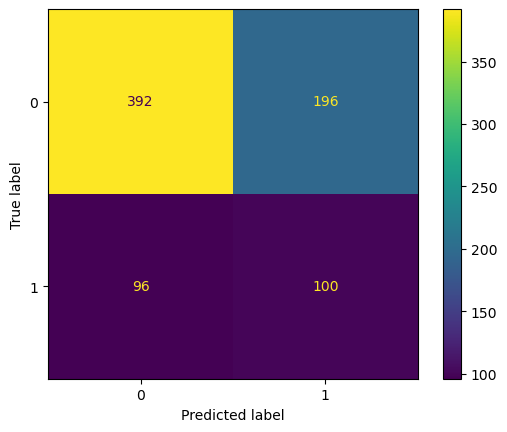

In [112]:
cm = confusion_matrix(test_y, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [113]:
#As you can see we have decreased the number of false negatives but 
#increased the number of false positives. Setting the threshold is a balanci9ng act

In [114]:
#Lets try another classifier:
#K nearest neighbors:

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(train_X, train_y)

KNeighborsClassifier()

In [115]:
y_pred = knn.predict(test_X)

score = f1_score(test_y, y_pred)
print(f'f1 score: {score}')

f1 score: 0.3898635477582846


In [116]:
#Lets do another grid search:

grid = {
    'n_neighbors': [3, 5, 7],
    'metric': ['euclidean', 'manhattan'],
    'weights': ['uniform', 'distance']
}

grid_clf = GridSearchCV(knn, grid, cv=5)
grid_clf.fit(train_X, train_y)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 7],
                         'weights': ['uniform', 'distance']})

In [117]:
grid_clf.best_estimator_

KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance')

In [118]:
best_knn = grid_clf.best_estimator_

y_pred = best_knn.predict(test_X)

score = f1_score(test_y, y_pred)
print(f'f1 score: {score}')

f1 score: 0.3856502242152466


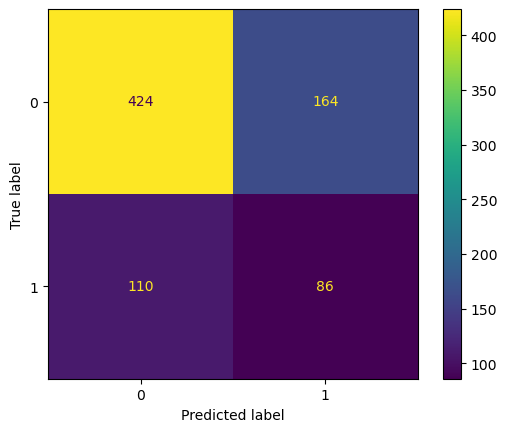

In [119]:
cm = confusion_matrix(test_y, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [120]:
from sklearn.naive_bayes import GaussianNB

nb_clf = GaussianNB()

nb_clf.fit(train_X, train_y)

GaussianNB()

In [121]:
y_pred = nb_clf.predict(test_X)

score = f1_score(test_y, y_pred)
print(f'f1 score: {score}')

f1 score: 0.35492957746478876


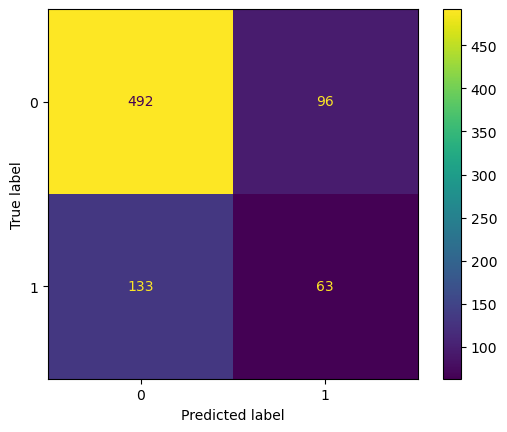

In [122]:
cm = confusion_matrix(test_y, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [123]:
#Now lets try to ensemble them all together!

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier


clf1 = LogisticRegression()
clf2 = DecisionTreeClassifier()
clf3 = GaussianNB()
clf4 = KNeighborsClassifier()
clf5 = SVC()
clf6 = rf_clf

ensemble = VotingClassifier(
    estimators=[('lr', clf1), 
                ('dt', clf2), 
                ('nb', clf3), 
                ('knn', clf4), 
                ('svc', clf5), 
                ('rf', clf6)], voting='hard')

ensemble.fit(train_X, train_y)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('dt', DecisionTreeClassifier()),
                             ('nb', GaussianNB()),
                             ('knn', KNeighborsClassifier()), ('svc', SVC()),
                             ('rf',
                              RandomForestClassifier(max_depth=16,
                                                     n_estimators=400))])

In [124]:
from sklearn.metrics import accuracy_score

y_pred = ensemble.predict(test_X)

acc = accuracy_score(test_y, y_pred)
score = f1_score(test_y, y_pred)
print(f'f1 score: {score} \n accuracy score: {acc}')


f1 score: 0.3932584269662921 
 accuracy score: 0.7244897959183674


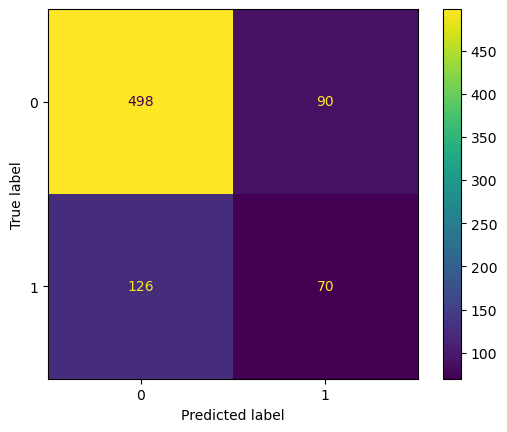

In [125]:
cm = confusion_matrix(test_y, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [126]:
# Lets make a neural network

from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(500,100, 50), max_iter=100, activation='relu', solver='adam')

mlp.fit(train_X, train_y)

MLPClassifier(hidden_layer_sizes=(500, 100, 50), max_iter=100)

f1 score: 0.3850267379679144


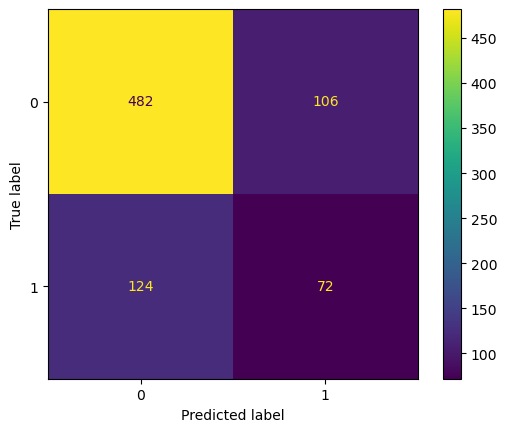

In [127]:
y_pred = mlp.predict(test_X)

score = f1_score(test_y, y_pred)
print(f'f1 score: {score}')

cm = confusion_matrix(test_y, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [128]:


keras_model = tf.keras.Sequential([
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

In [129]:
LEARNING_RATE = 0.1

X_train, X_val, y_train, y_val = train_test_split(train_X, train_y, test_size=0.2)

X_train = np.array(train_X)
y_train = np.array(train_y)

X_val = np.array(X_val)
y_val = np.array(y_val)

X_test = np.array(test_X)
y_test = np.array(test_y)

X_train = tf.convert_to_tensor(X_train)
y_train = tf.convert_to_tensor(y_train)

X_val = tf.convert_to_tensor(X_val)
y_val = tf.convert_to_tensor(y_val)

X_test = tf.convert_to_tensor(X_test)
y_test = tf.convert_to_tensor(y_test)


es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)
lrr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=7, 
                                            factor=0.5, 
                                            min_lr=0.00001)

adam = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)


precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()

keras_model.compile(
    optimizer=adam,
    loss='binary_crossentropy',
    metrics=['accuracy', recall, precision],
)


history = keras_model.fit(X_train, y_train, epochs=200, validation_data=(X_val, y_val), callbacks=[es, lrr])

Epoch 1/200

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



184/184 [==============================] - 1s 6ms/step - loss: 0.7183 - accuracy: 0.5666 - recall_1: 0.4435 - precision_1: 0.5256 - val_loss: 0.6702 - val_accuracy: 0.6262 - val_recall_1: 0.6112 - val_precision_1: 0.5850
Epoch 2/200
184/184 [==============================] - 1s 4ms/step - loss: 0.6949 - accuracy: 0.5680 - recall_1: 0.4477 - precision_1: 0.5272 - val_loss: 0.7585 - val_accuracy: 0.6109 - val_recall_1: 0.3551 - val_precision_1: 0.6271
Epoch 3/200
184/184 [==============================] - 1s 5ms/step - loss: 0.7065 - accuracy: 0.5707 - recall_1: 0.4574 - precision_1: 0.5302 - val_loss: 0.6652 - val_accuracy: 0.5514 - val_recall_1: 0.0598 - val_precision_1: 0.5614
Epoch 4/200
184/184 [==============================] - 1s 4ms/step - loss: 0.6963 - accuracy: 0.5753 - recall_1: 0.4739 - precision_1: 0.5352 - val_loss: 0.6514 - val_accuracy: 0.5939 - val_recall_1: 0.2280 - val_precision_1: 0.6524
Epoch 5/200
184/184 [==============================] - 1s 4ms/step - loss: 0.702

f1 score: 0.4507042253521127


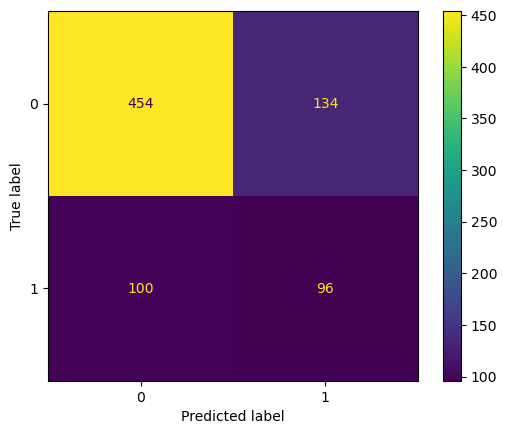

In [130]:
y_pred = keras_model.predict(test_X)
threshold = 0.5

y_pred = np.where(y_pred > threshold, 1, 0)


score = f1_score(y_test, y_pred)
print(f'f1 score: {score}')

cm = confusion_matrix(test_y, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

# PCA analysis

We will perform a PCA on the training set, apply it to both the train and test set then do our analyses again

In [131]:
train_X

array([[-0.02916307, -0.07189848, -0.05984801, ..., -0.19489065,
        -0.42308758,  0.04601955],
       [-0.02916307, -0.07189848, -0.05984801, ...,  1.60250208,
        -0.42308758, -0.5721974 ],
       [-0.02916307, -0.07189848, -0.05984801, ...,  0.70380572,
        -0.42308758, -0.5721974 ],
       ...,
       [-0.02916307, -0.07189848, -0.05984801, ..., -0.19489065,
        -0.42308758, -0.5721974 ],
       [-0.02916307, -0.07189848, -0.05984801, ...,  0.70380572,
        -0.42308758, -0.5721974 ],
       [-0.02916307, -0.07189848, -0.05984801, ...,  1.60250208,
         0.25357655,  0.66423649]])

In [132]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA(n_components=10)
scale = StandardScaler()

scale.fit(train_X)
train_X_scaled = scale.transform(train_X)
test_X_scaled = scale.transform(test_X)

pca.fit(train_X_scaled)

PCA(n_components=10)

In [133]:
X_train_pca = pca.transform(train_X)
X_test_pca = pca.transform(test_X)

In [134]:
def plot_cum_var (pca):
    cum_var_exp = np.cumsum(pca.explained_variance_ratio_)
    features = range(pca.n_components_)
    plt.bar(features, pca.explained_variance_ratio_, color='black')
    plt.step(range(0, pca.n_components_), cum_var_exp, where='mid', label='cumulative explained variance', color='red')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.xticks(range(1, 9))
    plt.legend(loc='best')
    plt.tight_layout()

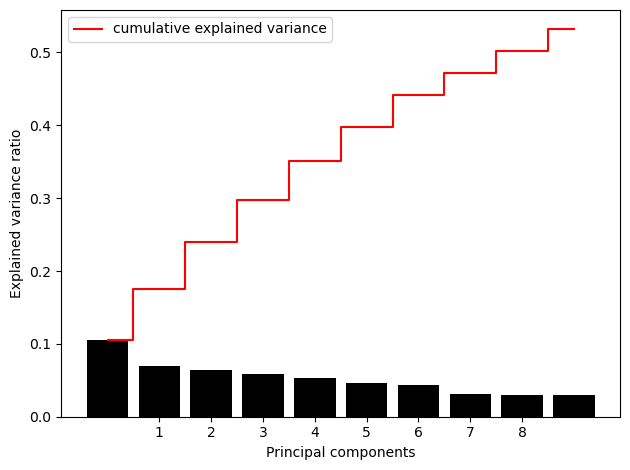

In [135]:
plot_cum_var(pca)

In [136]:
PCA_components = pd.DataFrame(X_train_pca)

PCA_components.head()

,0,1,2,3,4,5,6,7,8,9
0,-1.334015,3.247458,7.336423,-2.912894,3.800256,10.164780,-1.792281,-0.242825,-0.311342,-0.030276
1,13.432988,0.412000,1.413458,5.998163,3.106770,0.069885,-0.937789,-0.312709,1.735464,-0.108053
2,-0.047760,0.954508,0.149152,0.274849,-3.072808,0.557791,0.750734,-0.186551,-1.698612,0.764616
3,0.169165,3.595894,0.116530,-0.404685,0.708576,11.779119,-0.481088,0.269074,0.226332,0.056753
4,-0.492523,0.017207,-0.170771,0.308731,-0.335086,0.201614,0.511841,0.679153,0.586608,-0.311107


In [137]:
train_y

5952    1
6114    1
3130    1
2491    1
1312    1
       ..
1899    0
2763    0
4538    0
4237    0
1354    0
Name: tox_bin, Length: 5884, dtype: int64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


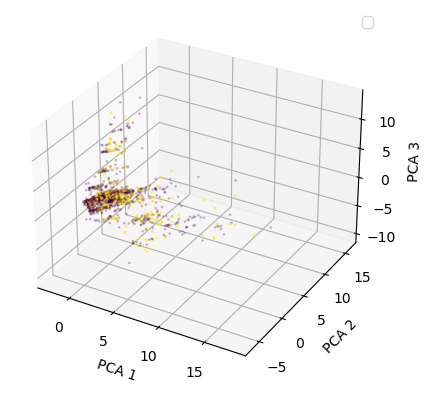

In [138]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
markers = ['o', '^']


ax.scatter(PCA_components[0], PCA_components[1], PCA_components[2], c=train_y, cmap='viridis', s=1, alpha=0.2)
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
ax.legend()

In [139]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier()
sgd.fit(X_train_pca, train_y)

SGDClassifier()

In [140]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd, X_test_pca, test_y, cv =3, scoring='accuracy')

array([0.40839695, 0.66666667, 0.55172414])

In [141]:
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_predict

y_scores = cross_val_predict(sgd, PCA_components, train_y, cv=5, method='decision_function')

precisions, recalls, thresholds = precision_recall_curve(train_y, y_scores)

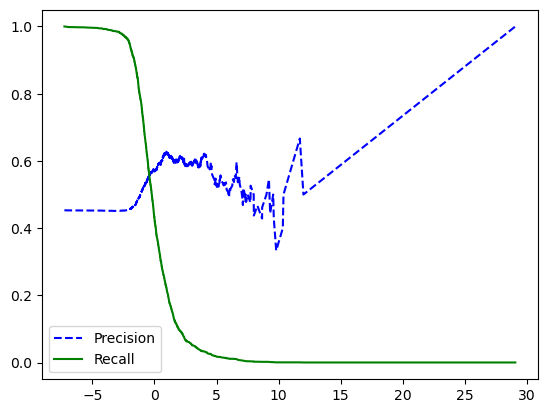

In [142]:
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
plt.legend()

In [143]:
y_pred = sgd.predict(X_test_pca)
score = f1_score(test_y, y_pred)

print('f1 score: ', score)

f1 score:  0.14814814814814814


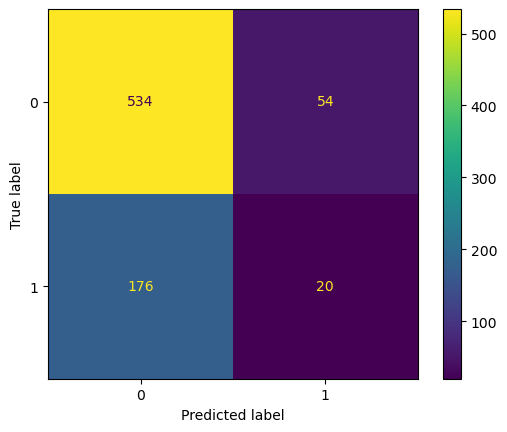

In [144]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(test_y, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [145]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train_pca, train_y)

RandomForestClassifier()

In [146]:
y_pred = rf.predict(X_test_pca)

score = f1_score(test_y, y_pred)
print(f'f1 score: {score}')

f1 score: 0.3400576368876081


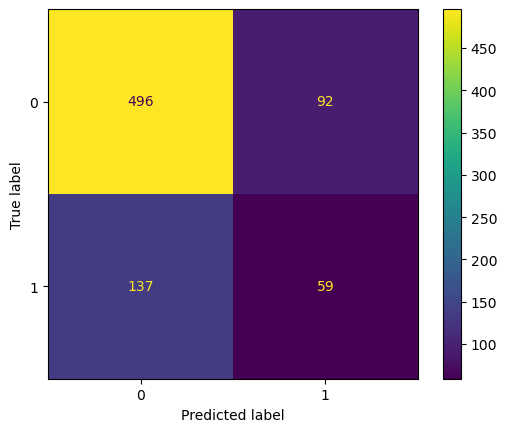

In [147]:
cm = confusion_matrix(test_y, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [148]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

rf_clf = RandomForestClassifier(criterion='gini', max_features='log2')

grid = {
    'n_estimators': [350,400,450],
    'max_depth' : [12,13,14,15,16],
}

scoring = make_scorer(f1_score)

grid_search = GridSearchCV(estimator=rf_clf, param_grid=grid, scoring=scoring, cv=5)

grid_search.fit(X_train_pca, train_y)

GridSearchCV(cv=5, estimator=RandomForestClassifier(max_features='log2'),
             param_grid={'max_depth': [12, 13, 14, 15, 16],
                         'n_estimators': [350, 400, 450]},
             scoring=make_scorer(f1_score))

In [149]:
grid_search.best_params_

{'max_depth': 16, 'n_estimators': 450}

In [150]:
rf_clf = RandomForestClassifier(**grid_search.best_params_)
rf_clf.fit(X_train_pca, train_y)

RandomForestClassifier(max_depth=16, n_estimators=450)

In [151]:
y_pred = rf_clf.predict(X_test_pca)

score = f1_score(test_y, y_pred)
print(f'f1 score: {score}')

f1 score: 0.35492957746478876


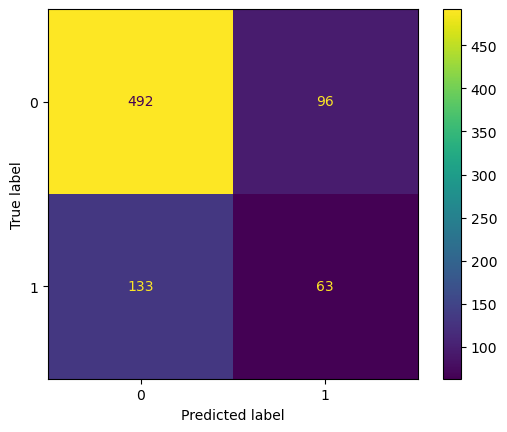

In [152]:
cm = confusion_matrix(test_y, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [153]:
from sklearn.svm import SVC

svc_clf = SVC()
svc_clf.fit(X_train_pca, train_y)

SVC()

In [154]:
y_pred = svc_clf.predict(X_test_pca)

score = f1_score(test_y, y_pred)
print(f'f1 score: {score}')

f1 score: 0.40540540540540543


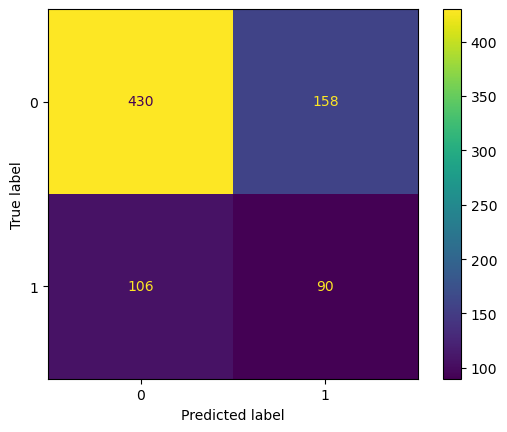

In [155]:
cm = confusion_matrix(test_y, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [156]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_pca, train_y)

KNeighborsClassifier()

In [157]:
y_pred = knn_clf.predict(X_test_pca)

score = f1_score(test_y, y_pred)
print(f'f1 score: {score}')

f1 score: 0.4233009708737864


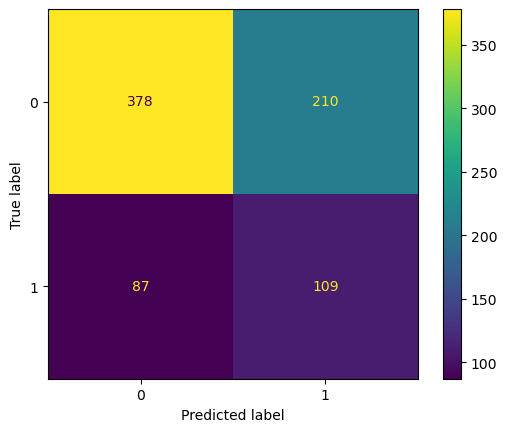

In [158]:
cm = confusion_matrix(test_y, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [159]:
from sklearn.naive_bayes import GaussianNB

nb_clf = GaussianNB()
nb_clf.fit(X_train_pca, train_y)

GaussianNB()

In [160]:
y_pred = nb_clf.predict(X_test_pca)

score = f1_score(test_y, y_pred)
print(f'f1 score: {score}')

f1 score: 0.34929577464788736


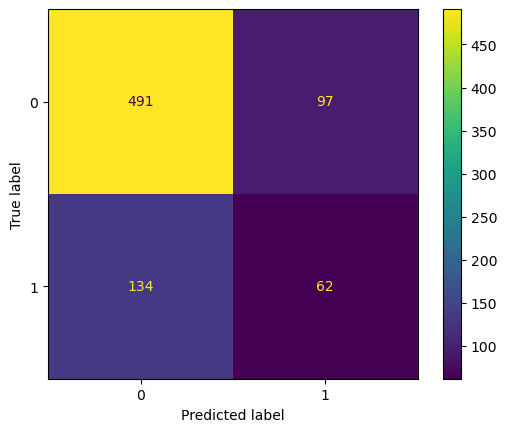

In [161]:
cm = confusion_matrix(test_y, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [162]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

clf1 = LogisticRegression()
clf2 = DecisionTreeClassifier()
clf3 = nb_clf
clf4 = knn_clf
clf5 = svc_clf
clf6 = rf_clf

In [163]:
ensemble_clf = VotingClassifier(
    estimators=[('lr', clf1),
                ('dt', clf2),
                ('nb', clf3),
                ('knn', clf4),
                ('svc', clf5),
                ('rf', clf6)],
    voting='hard'
)

ensemble_clf.fit(X_train_pca, train_y)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('dt', DecisionTreeClassifier()),
                             ('nb', GaussianNB()),
                             ('knn', KNeighborsClassifier()), ('svc', SVC()),
                             ('rf',
                              RandomForestClassifier(max_depth=16,
                                                     n_estimators=450))])

In [164]:
y_pred = ensemble_clf.predict(X_test_pca)

score = f1_score(test_y, y_pred)
print(f'f1 score: {score}')

f1 score: 0.3723723723723724


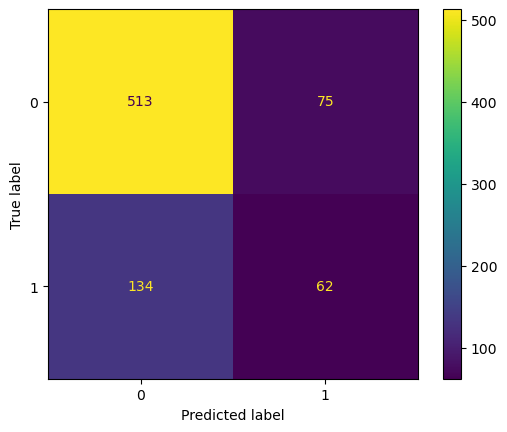

In [165]:
cm = confusion_matrix(test_y, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [166]:
LEARNING_RATE = 0.5


keras_model = tf.keras.Sequential([
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

In [167]:
X_train, X_val, y_train, y_val = train_test_split(X_train_pca, train_y, test_size=0.2)

X_train = np.array(train_X)
y_train = np.array(train_y)

X_val = np.array(X_val)
y_val = np.array(y_val)

X_test = np.array(test_X)
y_test = np.array(test_y)

X_train = tf.convert_to_tensor(X_train)
y_train = tf.convert_to_tensor(y_train)

X_val = tf.convert_to_tensor(X_val)
y_val = tf.convert_to_tensor(y_val)

X_test = tf.convert_to_tensor(X_test)
y_test = tf.convert_to_tensor(y_test)


es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)
lrr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=7, 
                                            factor=0.5, 
                                            min_lr=0.00001)

adam = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)


precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()

keras_model.compile(
    optimizer=adam,
    loss='binary_crossentropy',
    metrics=['accuracy', recall, precision],
)


history = keras_model.fit(X_train_pca, y_train, epochs=200, validation_data=(X_val, y_val), callbacks=[es, lrr])

Epoch 1/200
184/184 [==============================] - 1s 7ms/step - loss: 1.5490 - accuracy: 0.5238 - recall_2: 0.4574 - precision_2: 0.4734 - val_loss: 1.2592 - val_accuracy: 0.6177 - val_recall_2: 0.7877 - val_precision_2: 0.5573
Epoch 2/200
184/184 [==============================] - 1s 6ms/step - loss: 1.7030 - accuracy: 0.5184 - recall_2: 0.4597 - precision_2: 0.4677 - val_loss: 1.9485 - val_accuracy: 0.4121 - val_recall_2: 0.5307 - val_precision_2: 0.3931
Epoch 3/200
184/184 [==============================] - 1s 6ms/step - loss: 1.5535 - accuracy: 0.5161 - recall_2: 0.4533 - precision_2: 0.4650 - val_loss: 1.4605 - val_accuracy: 0.6151 - val_recall_2: 0.3333 - val_precision_2: 0.6533
Epoch 4/200
184/184 [==============================] - 1s 6ms/step - loss: 1.2876 - accuracy: 0.5165 - recall_2: 0.4574 - precision_2: 0.4656 - val_loss: 1.1555 - val_accuracy: 0.5786 - val_recall_2: 0.1322 - val_precision_2: 0.7030
Epoch 5/200
184/184 [==============================] - 1s 6ms/step -

In [168]:
y_pred = keras_model.predict(X_test_pca)

threshold = 0.5

y_pred = np.where(y_pred > 0.5, 1, 0)

score = f1_score(test_y, y_pred)
print(f'f1 score: {score}')

f1 score: 0.44955752212389377


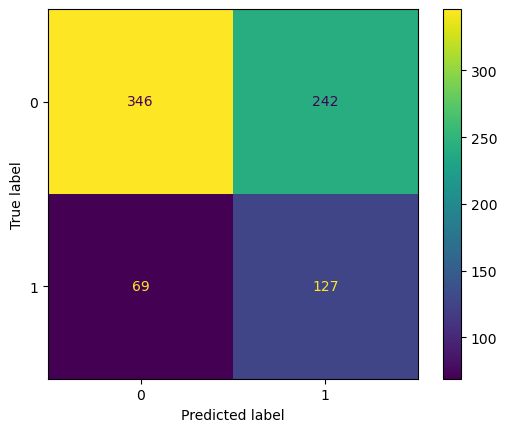

In [169]:
cm = confusion_matrix(test_y, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [1]:
import model_stats as ms